# Udacity Carnd-term1
## P4 Advanced Lane Lines
### Zheng lei
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

## Step0 camera calibration

Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cali*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    print(fname,ret)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(200)

cv2.destroyAllWindows()

camera_cal\calibration1.jpg False
camera_cal\calibration10.jpg True
camera_cal\calibration11.jpg True
camera_cal\calibration12.jpg True
camera_cal\calibration13.jpg True
camera_cal\calibration14.jpg True
camera_cal\calibration15.jpg True
camera_cal\calibration16.jpg True
camera_cal\calibration17.jpg True
camera_cal\calibration18.jpg True
camera_cal\calibration19.jpg True
camera_cal\calibration2.jpg True
camera_cal\calibration20.jpg True
camera_cal\calibration3.jpg True
camera_cal\calibration4.jpg False
camera_cal\calibration5.jpg False
camera_cal\calibration6.jpg True
camera_cal\calibration7.jpg True
camera_cal\calibration8.jpg True
camera_cal\calibration9.jpg True


If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

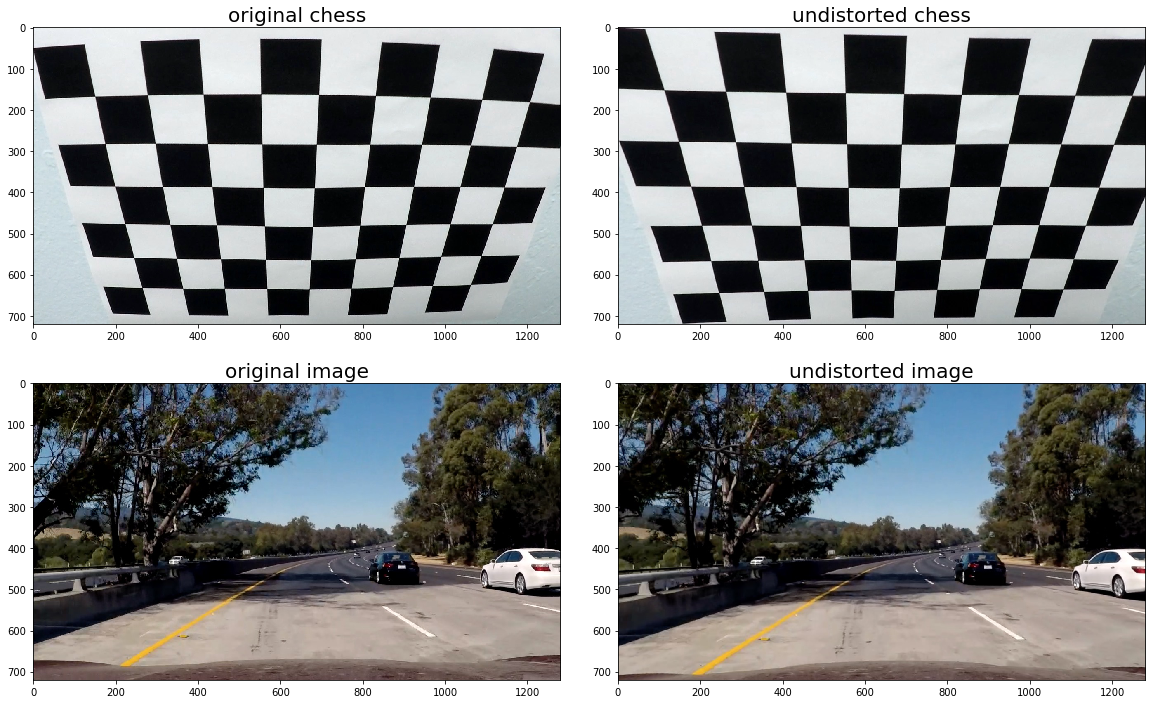

In [2]:
img = mpimg.imread('test_images/test5.jpg')

# Test undistortion on an image
chess = cv2.imread('camera_cal/calibration2.jpg')
img_size = (chess.shape[1], chess.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

chess_undistorted = undistort(chess)
img_undistorted = undistort(img)

# Visualize undistortion
f, ax = plt.subplots(2, 2, figsize=(20, 12))
f.subplots_adjust(hspace = 0.2, wspace= 0.1)
ax = ax.ravel()
ax[0].imshow(chess)
ax[0].set_title('original chess', fontsize=20)
ax[1].imshow(chess_undistorted, cmap='gray')
ax[1].set_title('undistorted chess', fontsize=20)
ax[2].imshow(img, cmap='gray')
ax[2].set_title('original image', fontsize=20)
ax[3].imshow(img_undistorted, cmap='gray')
ax[3].set_title('undistorted image', fontsize=20)
plt.savefig("readme_img/undistrorted.jpg")

## Step1 Perspective , bird eye view

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. The transform source and destination was selected mannually.

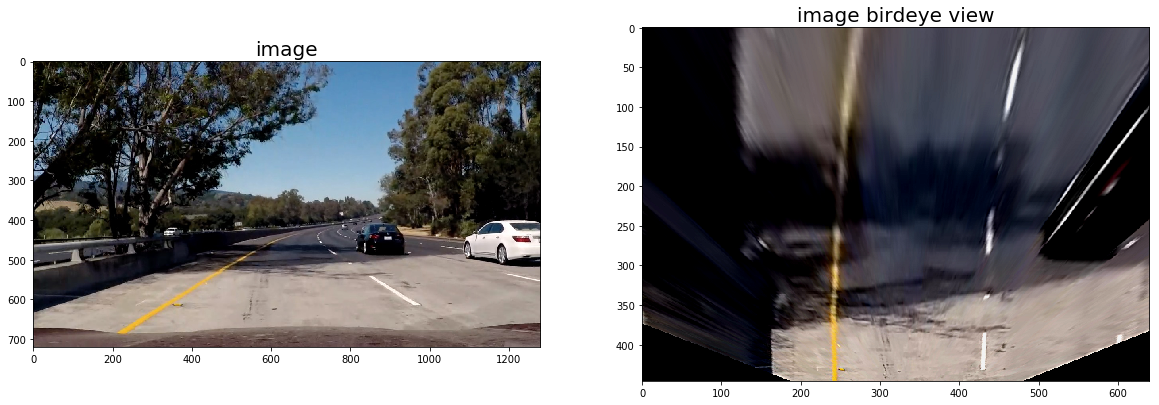

In [3]:
IMAGE_H = 446
IMAGE_W = 640

#show np.ndarray datatype
def showtype(data):
    print(type(data))
    print('shape:',data.shape)
    print('dtype:',data.dtype)
    print('------------------------------------------------')

# Sharpen image
def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

# Compute linear image transformation img*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

# Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

# Create perspective image transformation matrices
def create_M():
    #src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
    #dst = np.float32([[569, 223], [711, 223], [0, 0], [1280, 0]])

    src = np.float32([[0, 673], [1207, 673],[480, 450], [800, 450]])
    dst = np.float32([[188, 446], [462, 446], [0, 0], [640, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

# Main image transformation routine to get a warped image
def transform(img, M):
    undist = undistort(img)
    img_size = (IMAGE_W, IMAGE_H)
    warped = cv2.warpPerspective(undist, M, img_size)
    warped = sharpen_img(warped)
    warped = contr_img(warped, 1.1)
    return warped

def trans_binary(img, M):
    img_size = (IMAGE_W, IMAGE_H)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped


M, Minv = create_M()
img_birdeye = transform(img,M)

# Visualize undistortion
f, ax = plt.subplots(1, 2, figsize=(20, 12))
ax = ax.ravel()
ax[0].imshow(img)
ax[0].set_title('image', fontsize=20)
ax[1].imshow(img_birdeye, cmap='gray')
ax[1].set_title('image birdeye view', fontsize=20)
plt.savefig("readme_img/birdeye_view.jpg")

## Step2 Create a mask

Define a interesting area could drop the useless information of the image.

function for masking region of interest


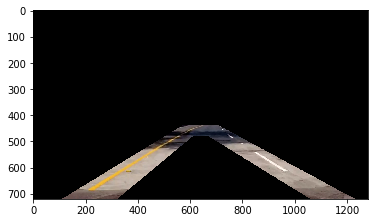

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def road_mask(img):
    imshape = img.shape
    left_bottom = (110, imshape[0])
    apex1 = (imshape[1]/2 - 70, 440)
    apex2 = (imshape[1]/2 + 70, 440)
    right_bottom = (imshape[1]-50, imshape[0])
    inner_right_bottom = (imshape[1] - 220, imshape[0])
    inner_apex2 = (imshape[1]/2 + 30,480)
    inner_apex1 = (imshape[1]/2 - 30,480)
    inner_left_bottom = (320, imshape[0])
    vertices = np.array([[left_bottom, apex1, apex2,right_bottom, inner_right_bottom,
                          inner_apex2, inner_apex1, inner_left_bottom]], dtype=np.int32)
    # Masked area
    mask_img = region_of_interest(img, vertices)
    return mask_img
    
print("function for masking region of interest")    
mask_img = road_mask(img)

plt.imshow(mask_img)
plt.savefig("readme_img/mask.jpg")

## Step3 Create of thresholded binary image

To extract information from the picture. An usefull way is using HLS(hue, lightness saturation) Color Spaces. At the following segment, you can see the lane is clear in S channel. In the S picture , at the tree shadows, there is a bright area, and the lightness channel could help us to discard these area.  

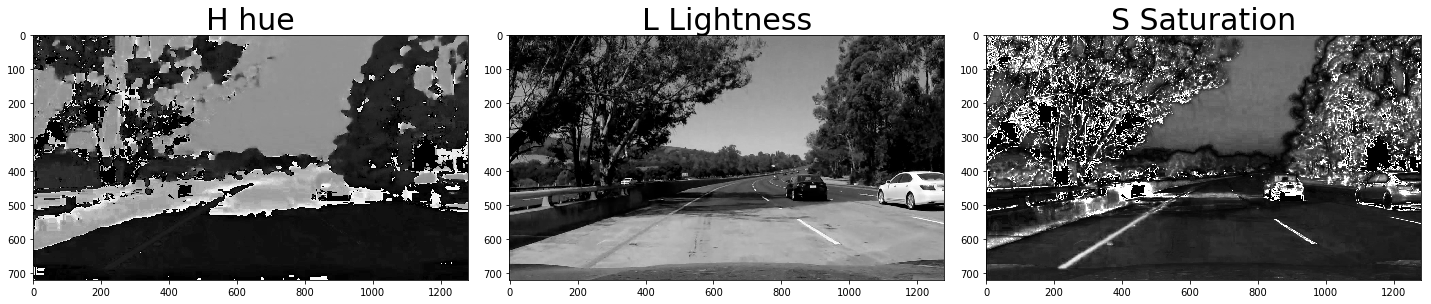

In [5]:
'''
In this lesson, we're looking at different color spaces. 
While there are several that are worth exploring, here we'll look specifically at HLS. 
When we separate the H, L, and S channels we get the following result:
'''

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0] 
L = hls[:,:,1]
S = hls[:,:,2]

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H hue', fontsize=30)
ax2.imshow(L, cmap='gray')
ax2.set_title('L Lightness', fontsize=30)
ax3.imshow(S, cmap='gray')
ax3.set_title('S Saturation', fontsize=30)
plt.savefig("readme_img/HLS.jpg")

Soble operator is like the gradient function. sobel derivative in x tells us the information about the lane, especially when the saturation is low. So we can combine soblex and saturation together. Then change them into binary format.

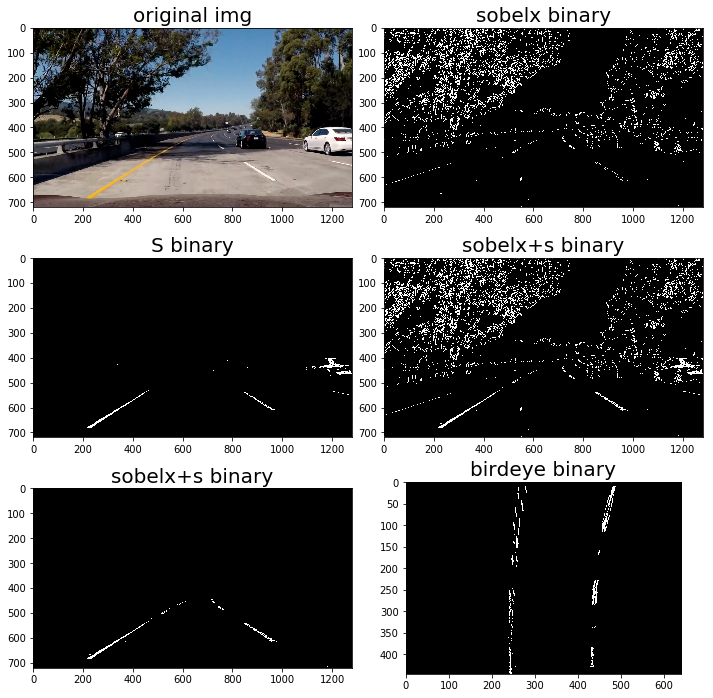

In [7]:
def binary_pipeline(img, s_thresh=(190, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) ] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])& (l_channel >= 50)] = 1
    
    # Stack each channel
    color_binary = sxbinary + s_binary
    color_binary[(color_binary >= 1) & (color_binary <= 255)] = 1
    
    return color_binary, s_binary , sxbinary

binary,s_binary,sxbinary = binary_pipeline(img)
mask_binary = road_mask(binary)
birdeye_binary = trans_binary(mask_binary, M)

f, ax = plt.subplots(3, 2, figsize=(12, 12))
f.subplots_adjust(hspace = 0.2, wspace= 0.1)
ax = ax.ravel()
ax[0].imshow(img)
ax[0].set_title('original img', fontsize=20)
ax[1].imshow(sxbinary, cmap='gray')
ax[1].set_title('sobelx binary', fontsize=20)
ax[2].imshow(s_binary, cmap='gray')
ax[2].set_title('S binary', fontsize=20)
ax[3].imshow(binary, cmap='gray')
ax[3].set_title('sobelx+s binary', fontsize=20)
ax[4].imshow(mask_binary, cmap='gray')
ax[4].set_title('sobelx+s binary', fontsize=20)
ax[5].imshow(birdeye_binary, cmap='gray')
ax[5].set_title('birdeye binary', fontsize=20)
plt.savefig("readme_img/birdeye_binary.jpg")

## Step4 find lane in bird view

After the above process, we have an binary birdey view of the lane. We want describe the lane in mathmatical way.
There is several methods to find the lane, and calculate the polynominal.

I use the "sliding window" method. I first calculate histogram of the binary image. Then define an window in the bottom of the image based on the max value of the histogram. Then calculate the average position of the white points in the window, and use the average as next window's center position.

We only interest on the white points in windows, and use "np.polyfit" to fitting the lane.

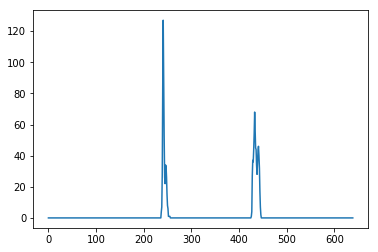

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
    
histogram = np.sum(birdeye_binary[birdeye_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[180:midpoint]) + 180
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
plt.savefig("readme_img/histogram.jpg")

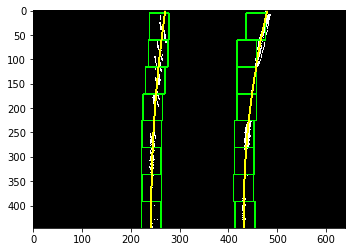

In [9]:
import copy
# find line in an binary image, output poly line
def findline(binary_image):
    histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[180:midpoint])+180
    rightx_base = np.argmax(histogram[midpoint:500]) + midpoint
    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_image.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 20
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = birdeye_binary.shape[0] - (window+1)*window_height
        win_y_high = birdeye_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    
    if righty.size > 0 :
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = left_fit
        right_fit[2] = left_fit[2] + 181
    
    # Fit a second order polynomial to each
    out_img_poly = copy.deepcopy(out_img)
    ploty = np.linspace(0, IMAGE_H -1, IMAGE_H )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    for i in range(IMAGE_H):
        for j in range(IMAGE_W):
            if (j>= left_fitx[i]-2 and j<= left_fitx[i]+2) or (j>= right_fitx[i]-2 and j<= right_fitx[i]+2):
                out_img_poly[i,j] = (255,255,0)
    
    return left_fit,right_fit,out_img,out_img_poly

left,right,slide_window,slide_window_poly = findline(birdeye_binary)
plt.imshow(slide_window_poly)
plt.savefig("readme_img/slide_windwo_poly.jpg")

## step5 draw road area
Now,we have two 2nd order polynominal.Then we can fill the road area with color. I fill the area use "for" loop, it's efficiency is not the best. I think there could be other method. Then I transform the birdeye view to normal view.

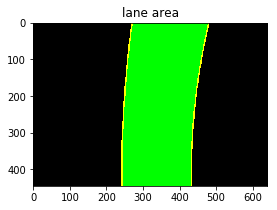

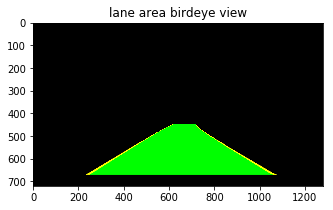

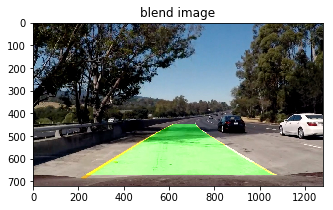

In [10]:
def draw_area(left_poly,right_poly):
    # Generate x and y values for plotting
    ploty = np.linspace(0, IMAGE_H -1, IMAGE_H )
    left_fitx = left_poly[0]*ploty**2 + left_poly[1]*ploty + left_poly[2]
    right_fitx = right_poly[0]*ploty**2 + right_poly[1]*ploty + right_poly[2]
    mask = np.zeros(shape = (IMAGE_H,IMAGE_W,3), dtype=np.uint8)

    for i in range(IMAGE_H):
        for j in range(IMAGE_W):
            if j> left_fitx[i] and j< right_fitx[i]:
                mask[i,j] = (0,255,0)
            if (j>= left_fitx[i]-2 and j<= left_fitx[i]+2) or (j>= right_fitx[i]-2 and j<= right_fitx[i]+2):
                mask[i,j] = (255,255,0)
    return mask

lane_area = draw_area(left,right)
lane_area_birdview = cv2.warpPerspective(lane_area, Minv, (1280, 720)) 
blend = cv2.addWeighted(img,1.0,lane_area_birdview,0.5,0.0)

# Visualize undistortion
plt.figure(figsize=(6,3))
plt.title('lane area')
plt.imshow(lane_area)
plt.savefig("readme_img/lane_area.jpg")
plt.figure(figsize=(6,3))
plt.title('lane area birdeye view')
plt.imshow(lane_area_birdview)
plt.figure(figsize=(6,3))
plt.title('blend image')
plt.imshow(blend)
plt.savefig("readme_img/blend_image.jpg")

## Step 6 Road radius and Car positon

In this chapter, I build two function to calculate car position and lane curvature. We assume the camare is mounted in the middle of the car. So the car postion is compare the diffrence between the middle of the lane and the image center.

In [11]:
xm_per_pix = 30 / 640 
ym_per_pix = 100 / 446 

def find_car_position(left_fit,right_fit):
    left_lane_pix = left_fit[0]*(IMAGE_H - 1)**2 + left_fit[1]*(IMAGE_H - 1) + left_fit[2]
    right_lane_pix = right_fit[0]*(IMAGE_H - 1)**2 + right_fit[1]*(IMAGE_H - 1) + right_fit[2]
    
    offset_pix = IMAGE_W/2.0- (left_lane_pix + right_lane_pix)/2.0
    offset_m = offset_pix*xm_per_pix
    return offset_m

# Calculate radius of curvature of a line
def measuring_curvature(fit):
    ploty = np.linspace(0, IMAGE_H -1, IMAGE_H )# to cover same y-range as image
    leftx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    if curverad > 10000:
        curverad = 10000
    return curverad

car_position = find_car_position(left,right)
radius = measuring_curvature(left)
print('car position is: ',car_position,'m')
print('curverad is:',radius, 'm')

car position is:  -0.765318570852 m
curverad is: 3290.11237329 m


## Step 7 Process image pipeline

An pipeline read in the image and return an marked image.I also add intermediate image to the output.These sub-image help me to diagnotic the pipeline, easy to find the problems.I think it is very useful.

The pipe line have several steps:  
1. undistort the image  
2. build binary image using soble-x, lightness and saturation  
3. mask the binary image
4. Transfer to birdeye view
5. Find lane in the image, fit the lane using 2nd order polynominal
6. Draw lane area in the image 
7. resize and convert sub-image for diagnostic
8. write comment
9. Calculate car position and lane curvature , and write them on image

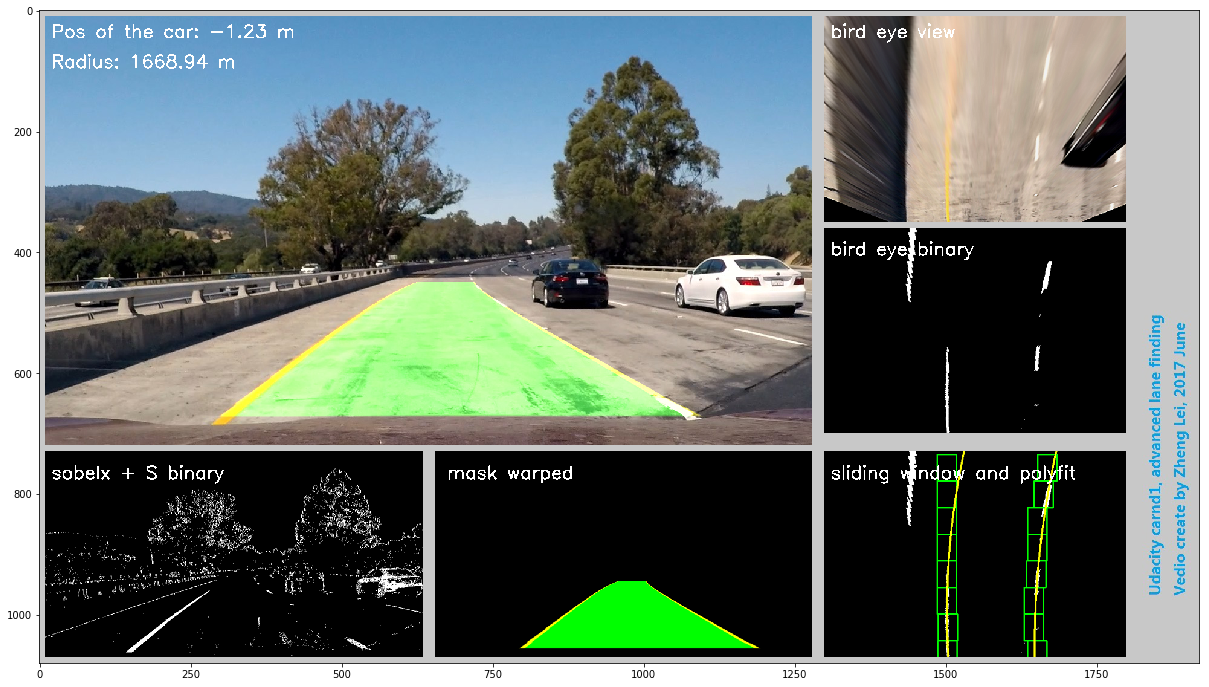

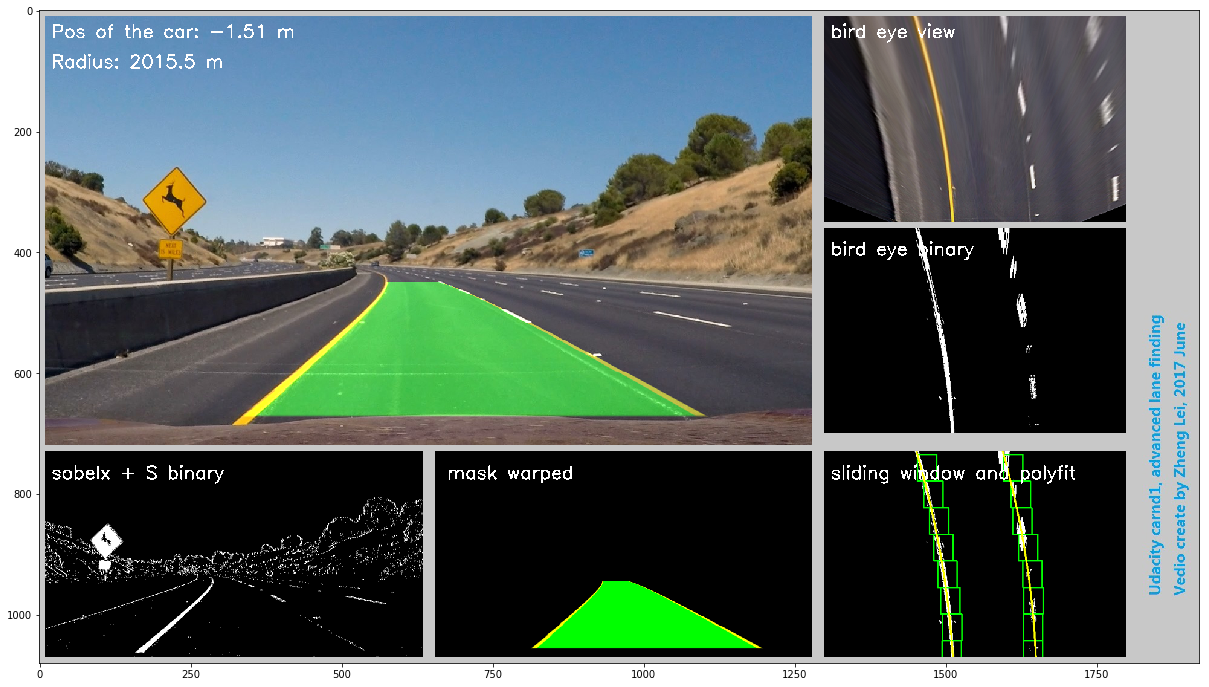

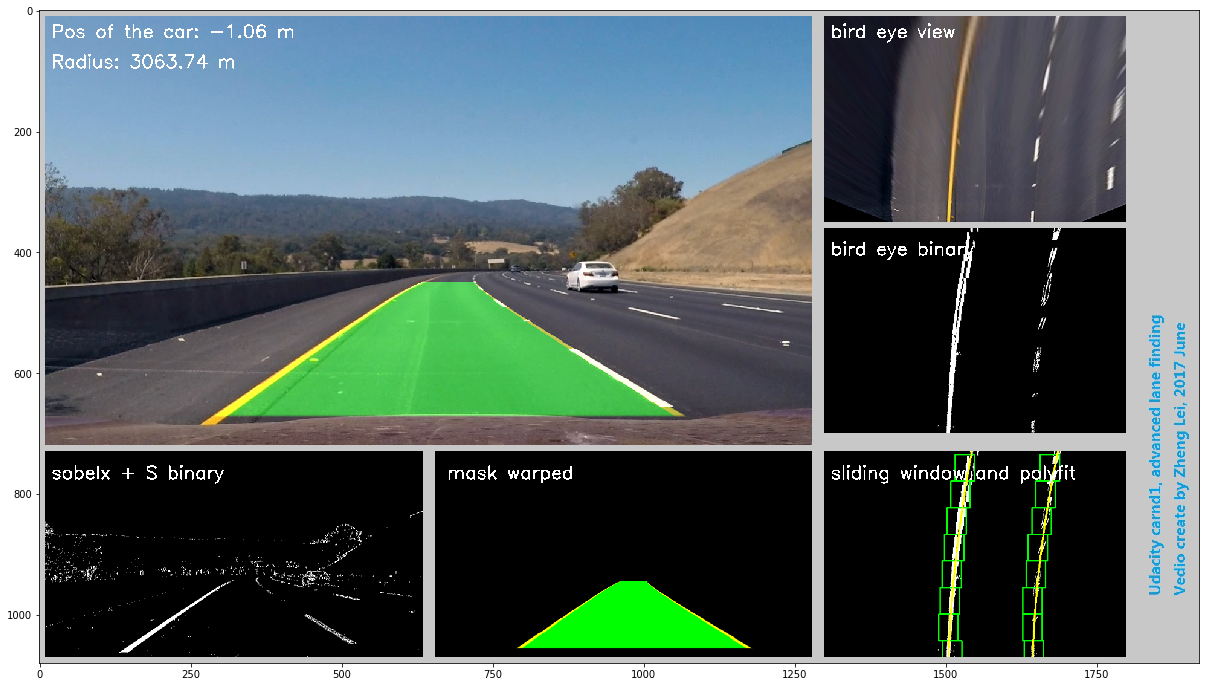

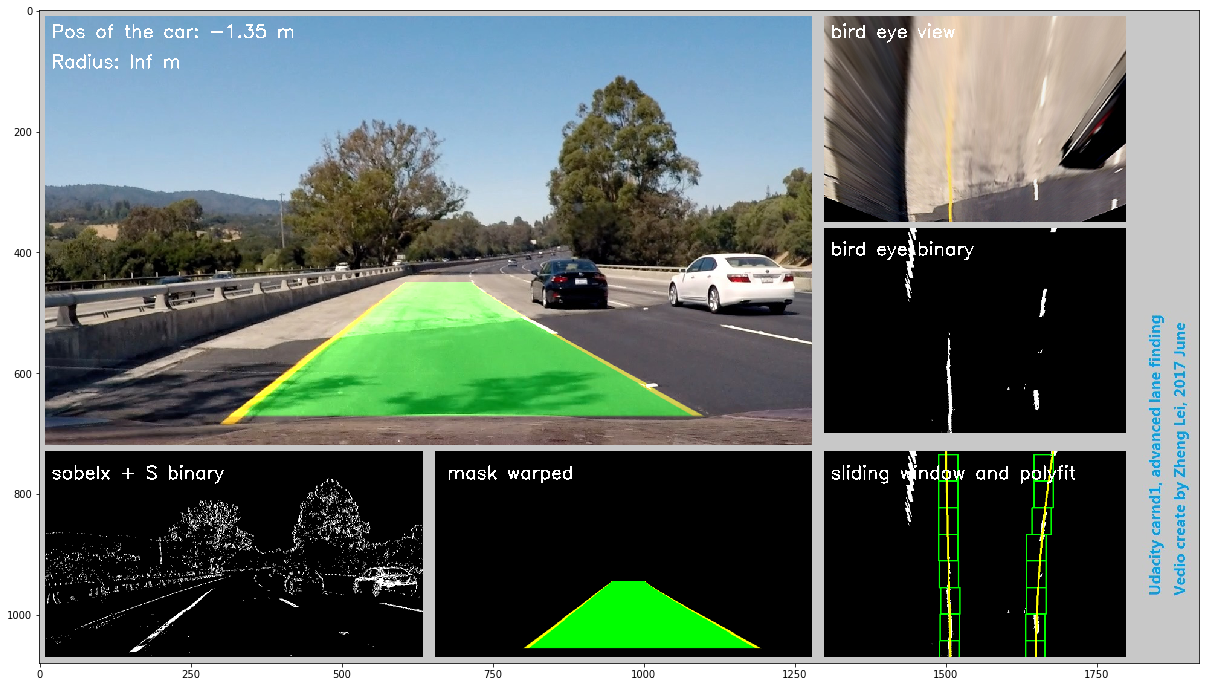

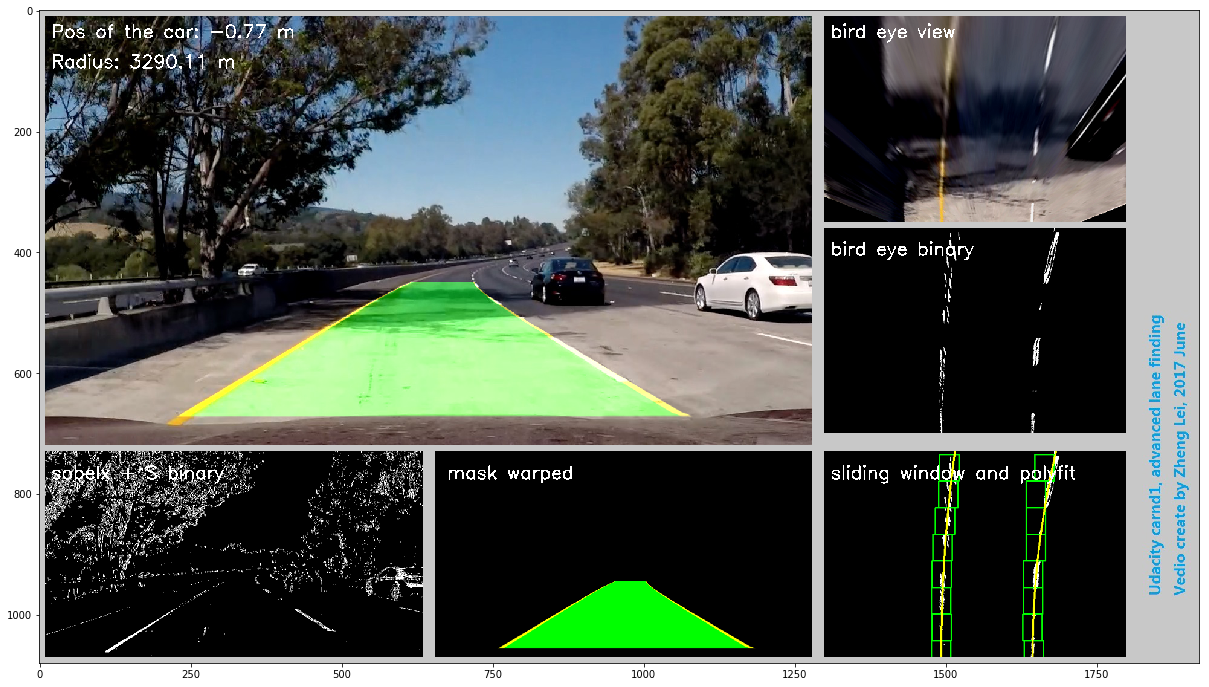

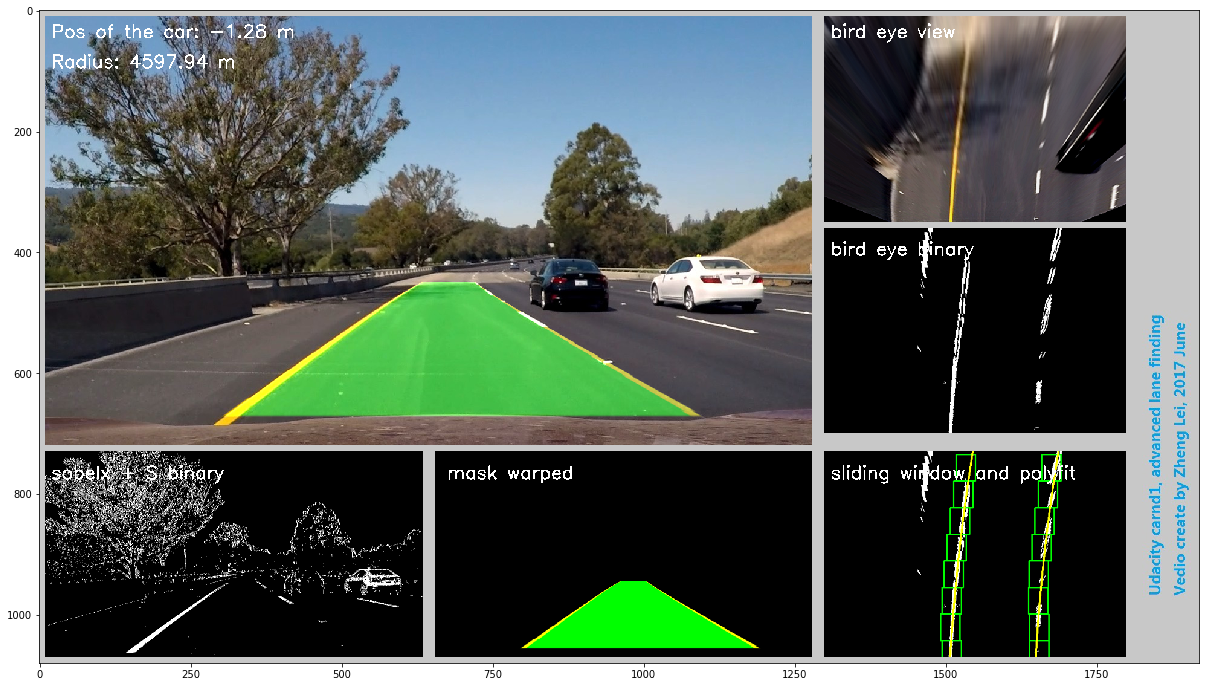

In [12]:
name_image =  mpimg.imread('name.jpg')
###
def process_image_P4(image):
    #Step1 undistort
    undistort_image = undistort(image)
    
    #Step2 binary image using soblex, lightness and saturation
    binary,s_binary,sxbinary = binary_pipeline(image)
    
    #Step3 Transfer to birdeye view
    mask_binary = road_mask(binary)
    
    #Step4 Transfer to birdeye view
    birdeye_binary = trans_binary(mask_binary, M)
    
    #Step5 Find line
    left,right,slide_window,slide_window_poly = findline(birdeye_binary)
    
    #Step6 Draw lane area in the image 
    mask = draw_area(left,right)
    maskwarp = cv2.warpPerspective(mask, Minv, (1280, 720)) 
    blend = cv2.addWeighted(image,1.0,maskwarp,0.5,0.0)
    
    #Step7 resize and convert sub-image for diagnostic
    img_birdeye = transform(undistort_image,M)
    img_birdeye_resize = cv2.resize(img_birdeye,None,fx=0.8,fy =0.8)
    binary_RGB = np.dstack((binary,binary,binary))*255#convert gray to RGB
    binary_resize = cv2.resize(binary_RGB,None,fx=0.5,fy =0.5)
    slide_window_poly_resize = cv2.resize(slide_window_poly,None,fx=0.8,fy =0.8)
    birdeye_binary_RGB = np.dstack((birdeye_binary,birdeye_binary,birdeye_binary))*255#convert gray to RGB
    birdeye_binary_resize = cv2.resize(birdeye_binary_RGB,None,fx=0.8,fy =0.8)
    maskwarp_resize = cv2.resize(maskwarp,None,fx=0.5,fy =0.5)
    #add subimage to process view
    process_view = np.zeros((1080,1920,3), dtype=np.uint8)#creat empty image
    process_view.fill(200)
    process_view[10:720, 10:1280] = blend[10:720, 10:1280]
    process_view[10:350, 1300:1800] = img_birdeye_resize[0:340,0:500]
    process_view[730:1070, 10:635] = binary_resize[10:350,10:635]
    process_view[360:700, 1300:1800] = birdeye_binary_resize[0:340,0:500]
    process_view[730:1070, 1300:1800] = slide_window_poly_resize[0:340,0:500]
    process_view[730:1070, 655:1280] = maskwarp_resize[10:350,10:635]
    process_view[400:1000, 1810:1920] = name_image
    
    #Step8 write comment
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(process_view,'bird eye view ',(1310,45), font, 1,(255,255,255),2)
    cv2.putText(process_view,'sobelx + S binary ',(20,775), font, 1,(255,255,255),2)
    cv2.putText(process_view,'bird eye binary ',(1310,405), font, 1,(255,255,255),2)
    cv2.putText(process_view,'sliding window and polyfit ',(1310,775), font, 1,(255,255,255),2)
    cv2.putText(process_view,'mask warped ',(675,775), font, 1,(255,255,255),2)
    
    #Step9 car position and lane radius
    car_position = find_car_position(left,right)
    radius = np.round(measuring_curvature(left),2)
    if radius> 9999:
        radius = 'Inf'
    else:
        radius = str(radius)
    
    text_pos = 'Pos of the car: '+str(np.round((car_position),2))+ ' m'
    text_radius = 'Radius: '+ radius + ' m'
    cv2.putText(process_view,text_pos,(20,45), font, 1,(255,255,255),2)
    cv2.putText(process_view,text_radius,(20,95), font, 1,(255,255,255),2)
    
    #process_view = cv2.resize(process_view,(1280,720))
    
    return process_view

for image in glob.glob('test_images/test*.jpg'): # Example of warped image
    img=mpimg.imread(image)
    blend = process_image_P4(img)
    plt.figure(figsize=(24,12))
    plt.imshow(blend)
plt.savefig("readme_img/image_process.jpg")

## Create video

In [13]:
from moviepy.editor import VideoFileClip
output_name = 'test_videos_output/project_video_out_720.mp4'
clip1 = VideoFileClip('./project_video.mp4')
out_clip = clip1.fl_image(process_image_P4) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_out_720.mp4
[MoviePy] Writing video test_videos_output/project_video_out_720.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:42<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_out_720.mp4 

Wall time: 21min 43s
